<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Etv2_Project_SWI_SNF_shRNA_Candidate_gene_Expression_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Candidates for shRNA Knock Down testing of additional SWI/SNF Factors 

by Erik Skie

In [2]:
#@title load R
%load_ext rpy2.ipython

In [ ]:
#@title install R packages
%%R
install.packages("devtools")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("SummarizedExperiment", "SingleCellExperiment", "knitr", "LoomExperiment", "batchelor"))
devtools::install_github("immunogenomics/harmony")
devtools::install_github('theislab/kBET')
#devtools::install_version("spatstat", version = "1.64-1", repos = "http://cran.us.r-project.org")
#remotes::install_version("Seurat", version = "3.2.3")
remotes::install_github(repo = 'satijalab/seurat')
devtools::install_github('satijalab/seurat-wrappers')
devtools::install_github("cellgeni/sceasy")
install.packages("rliger")
remotes::install_github("rstudio/reticulate")
install.packages("SparseM")

In [4]:
#@title load library
%%R
library(Seurat)
library(SingleCellExperiment)
library(tidyverse)
library(magrittr)
#library(kable)

In [ ]:
#@title load and transform data to Seurat
%%R
system("wget -x -c -nH https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = readRDS(file = "gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")
sce = as(sce, "SingleCellExperiment")
print(sce)
rownames(sce) = rowData(sce)$name
colnames(sce)  = colData(sce)$barcodes
so = as.Seurat(sce, data = NULL)
so = CreateSeuratObject(counts = GetAssayData(so, slot = "counts"), meta.data = so@meta.data)
so[["percent.mt"]] = PercentageFeatureSet(so, pattern = "^mt-")
so[["percent.rpl"]] = PercentageFeatureSet(so, pattern = "^Rpl")
so[["percent.rps"]] = PercentageFeatureSet(so, pattern = "^Rps")
s.genes <- cc.genes$s.genes %>% str_to_title()
g2m.genes <- cc.genes$g2m.genes %>% str_to_title()
so <- CellCycleScoring(so, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
#normalize and scaling#
rownames(sce) = rownames(so)
colnames(sce) = colnames(so)
so <- SetAssayData(object = so, slot = "scale.data", new.data = assays(sce)$scaled_counts)
so <- SetAssayData(object = so, slot = "data", new.data = assays(sce)$normalized_counts)
#assign UMAP #
so[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(so@meta.data[,c("umap.V1", "umap.V2")]), key = "umap_", assay = DefaultAssay(so))
so

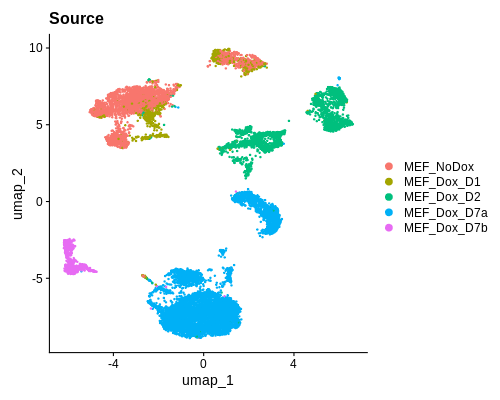

In [193]:
#@title plot UMAP
%%R -w 500 -h 400
Seurat::Idents(so) = "group"
p1 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = TRUE, raster = FALSE) + ggplot2::ggtitle(label = "Source")
Seurat::Idents(so) = "Phase"
p2 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = FALSE, raster = FALSE) + ggplot2::ggtitle(label = "Phase")
Seurat::Idents(so) = "cluster"
p3 <- Seurat::DimPlot(so, reduction = "umap", pt.size = 0.5, shuffle = FALSE, raster = FALSE) + ggplot2::ggtitle(label = "cluster")
p1

In [160]:
#@title get SWI/SNF supercomplex members from QuickGO database
%%R
swi = read.table(file = "/content/QuickGO-annotations-1620916285341-20210513.tsv", header = T, sep = "\t")
swi = swi$SYMBOL %>% unique() %>% tolower() %>% str_to_title()
swi = c(swi, "Chd7", "Vps72", "Cecr2", "Chd8", "Chek1", "Top1", "Dek") %>% unique()
message("SWI/SNF superfamily members")
print(swi)
message(sprintf("total members: %i", length(swi)))

R[write to console]: SWI/SNF superfamily members



  [1] "Smarcd1"                "Mcrs1"                  "Smarce1"               
  [4] "Nfrkb"                  "Mta2"                   "Inoc1"                 
  [7] "Smarcc2"                "Ss18"                   "Cecr2"                 
 [10] "Mbd3"                   "Arid1a"                 "Ino80"                 
 [13] "Smarcd3"                "Bptf"                   "Smarca2"               
 [16] "Smarca4"                "A0a0c4dfx4"             "Arid1b"                
 [19] "A0a384mtr5"             "A8k1n6"                 "A8k2v6"                
 [22] "A8k9i5"                 "B2r5v7"                 "B2rb07"                
 [25] "B3kma8"                 "Ruvbl2"                 "B3knw7"                
 [28] "B3krs7"                 "B3kxl9"                 "B4ddk2"                
 [31] "B4deg9"                 "B4df22"                 "B4df50"                
 [34] "B4dj22"                 "B4dj31"                 "B4djv8"                
 [37] "B4dk20"              

R[write to console]: total members: 147



In [ ]:
#@title differential expression testing of candidate genes
#@markdown testing the NoDox group individually against the Dox groups and then the NoDox group against all Dox groups, only looking for increased expression
%%R
Idents(so) = "group"
mdd1_markers = FindMarkers(so, ident.2 = "MEF_Dox_D1", ident.1 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd2_markers = FindMarkers(so, ident.2 = "MEF_Dox_D2", ident.1 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd7a_markers = FindMarkers(so, ident.2 = "MEF_Dox_D7a", ident.1 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
mdd7b_markers = FindMarkers(so, ident.2 = "MEF_Dox_D7b", ident.1 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)
all_markers = FindMarkers(so, ident.2 = c("MEF_Dox_D1", "MEF_Dox_D2", "MEF_Dox_D7a", "MEF_Dox_D7b"), ident.1 = "MEF_NoDox", test.use = "wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.1)

In [49]:
#@title Differential testing output
%%R
test = c("MEF_Dox_D1", "MEF_Dox_D2", "MEF_Dox_D7a", "MEF_Dox_D7b", "all")
markers = list(mdd1_markers, mdd2_markers, mdd7a_markers, mdd7b_markers, all_markers)
candidates = list()
for(i in 1:length(test)){
  temp = markers[[i]][which(rownames(markers[[i]]) %in% swi),]
  temp = temp[complete.cases(temp),]
  write.csv(temp, file = sprintf("NoDox_vs_%s.csv", test[[i]]))
  print(sprintf("Results for testing No Dox vs %s condition", test[[i]]))
  print(temp) 
  candidates = append(candidates, list(rownames(temp)))
}
#candidates  = Reduce(intersect, candidates) %>% unique()
#candidates = candidates %>% unlist() %>% as.vector()
#candidates = candidates[candidates != c("Smarca4")]
candidates = Reduce(intersect, candidates[2:5]) %>% unique()

[1] "Results for testing No Dox vs MEF_Dox_D1 condition"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
Smarca5 4.361663e-19  0.2646883 0.861 0.761 7.419188e-15
Pbrm1   6.536543e-08  0.1476801 0.794 0.664 1.111866e-03
Dek     7.952422e-07  0.1562443 0.870 0.831 1.352707e-02
[1] "Results for testing No Dox vs MEF_Dox_D2 condition"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
Smarca5  0.000000e+00  0.9307766 0.861 0.656  0.000000e+00
Pbrm1   3.319956e-225  0.7492844 0.794 0.581 5.647244e-221
Dek     5.103839e-220  0.7590216 0.870 0.720 8.681631e-216
Smarcc1  4.255132e-94  0.4049212 0.709 0.605  7.237980e-90
Ash1l    1.597359e-86  0.4333669 0.552 0.420  2.717108e-82
Bptf     3.398813e-78  0.3881752 0.604 0.467  5.781381e-74
Mbd2     2.793769e-69  0.3400122 0.453 0.322  4.752202e-65
Csnk2a1  3.728186e-68  0.3483295 0.583 0.489  6.341644e-64
Smarce1  2.221643e-65  0.3210540 0.806 0.746  3.779015e-61
Rbbp7    5.600183e-61  0.2897013 0.912 0.878  9.525911e-57
Gatad2a  

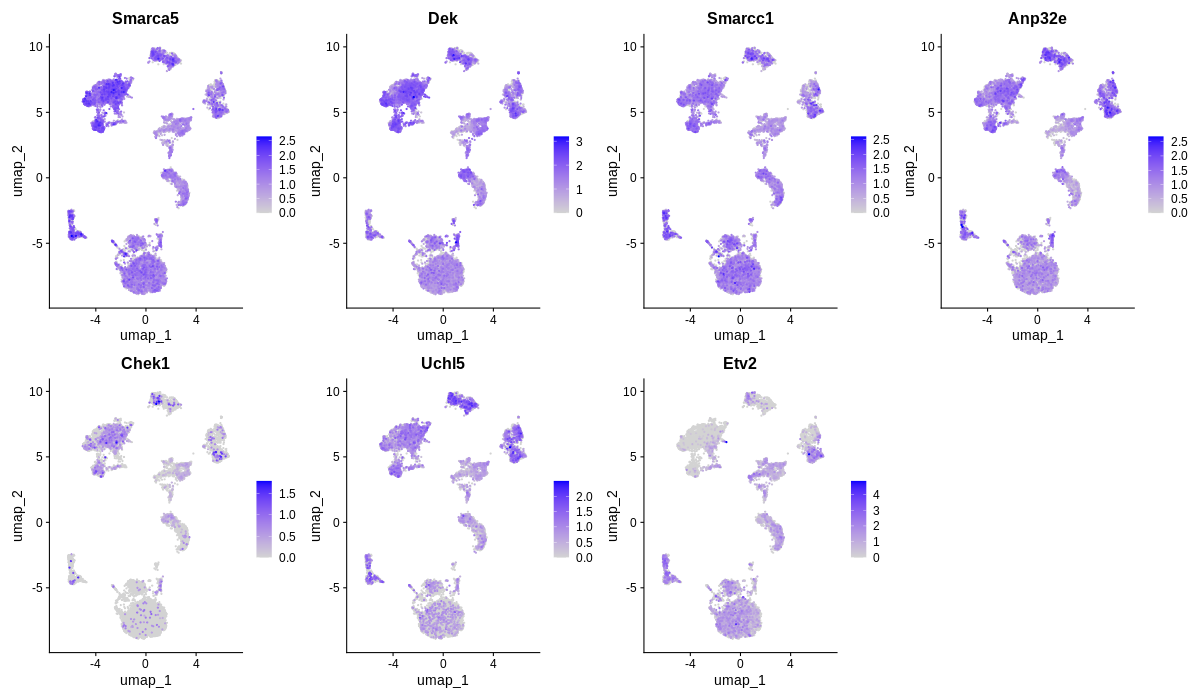

In [173]:
#@title UMAP plot expression of candidate genes
%%R -w 1200 -h 700
Genes = c(candidates, "Etv2")
FeaturePlot(so, dims = c(1, 2), features = Genes, pt.size = 0.4, cols = c('lightgrey', "blue"), ncol = 4, raster = FALSE, order = TRUE)

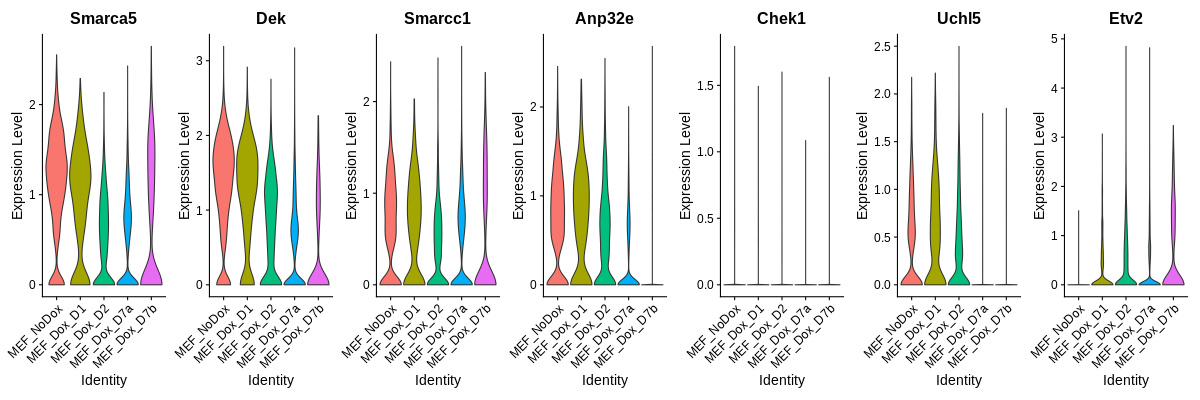

In [190]:
#@title Candidate genes
%%R -w 1200 -h 400
Genes = c(candidates, "Etv2")
Idents(so) = "group"
VlnPlot(so, features = Genes, ncol = 7, pt.size = 0)

In [53]:
#@title Read in Etv2 Bulk RNA seq data
%%R
se_rna <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))
se_rna <- DESeqDataSet(se_rna, design = ~ group)
se_rna <- estimateSizeFactors(se_rna)
se_rna <- DESeq(se_rna)
assays(se_rna)$normalized_counts <- log2(counts(se_rna, normalized = TRUE) + 1)
table(colData(se_rna)$group)

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



class: DESeqDataSet 
dim: 23429 10 
metadata(1): version
assays(5): counts mu H cooks normalized_counts
rownames(23429): 0610005C13Rik 0610007C21Rik ... a l7Rn6
rowData names(35): refseq_mrna baseMean ... deviance maxCooks
colnames: NULL
colData names(11): study_accession run ... align.summary.file
  sizeFactor


In [171]:
#@title gather Expression of candidate genes
%%R
Etv2_sum = mean(assays(se_rna["Etv2",])$normalized_counts)
Flk1_pos_average = list()
nd_average = list()
for(i in 1:length(candidates)){
    nd_average = append(nd_average, mean(assays(se_rna[candidates[i],c(9,10)])$normalized_counts))
    Flk1_pos_average = append(Flk1_pos_average, mean(assays(se_rna[candidates[i],c(7,8)])$normalized_counts))
}
names(Flk1_pos_average) = candidates
names(nd_average) = candidates

nd_average = nd_average %>% as.data.frame() %>% t()
nd_average = cbind(nd_average, rep("No Dox Etv2 Day 2.5", 8))
colnames(nd_average) = c("expression", "condition")

Flk1_pos_average = Flk1_pos_average %>% as.data.frame() %>% t()
Flk1_pos_average = cbind(Flk1_pos_average, rep("Dox Etv2 Day 2.5 Flk1+", 8))
colnames(Flk1_pos_average) = c("expression", "condition")

dat = rbind(nd_average, Flk1_pos_average)
dat = cbind(dat, rownames(dat))
colnames(dat) = c("expression", "condition", "candidates")
dat = dat %>% as.data.frame(dat)

dat$candidates = factor(dat$candidates, levels = c("Smarcc1", "Dek", "Anp32e", "Smarca5", "Uchl5", "Chek1"))
dat$condition = factor(dat$condition, levels = c("Dox Etv2 Day 2.5 Flk1+", "No Dox Etv2 Day 2.5"))
dat$expression = dat$expression %>% as.double()
dat$expression = lapply(dat$expression, function(x){round(x, 3)}) %>% as.character()
dat

   expression              condition candidates
1      11.643    No Dox Etv2 Day 2.5    Smarca5
2      13.634    No Dox Etv2 Day 2.5        Dek
3      14.258    No Dox Etv2 Day 2.5    Smarcc1
4      13.398    No Dox Etv2 Day 2.5     Anp32e
5      11.101    No Dox Etv2 Day 2.5      Chek1
6      11.391    No Dox Etv2 Day 2.5      Uchl5
7      11.466 Dox Etv2 Day 2.5 Flk1+    Smarca5
8      13.076 Dox Etv2 Day 2.5 Flk1+        Dek
9      13.674 Dox Etv2 Day 2.5 Flk1+    Smarcc1
10     12.732 Dox Etv2 Day 2.5 Flk1+     Anp32e
11     10.807 Dox Etv2 Day 2.5 Flk1+      Chek1
12     11.053 Dox Etv2 Day 2.5 Flk1+      Uchl5


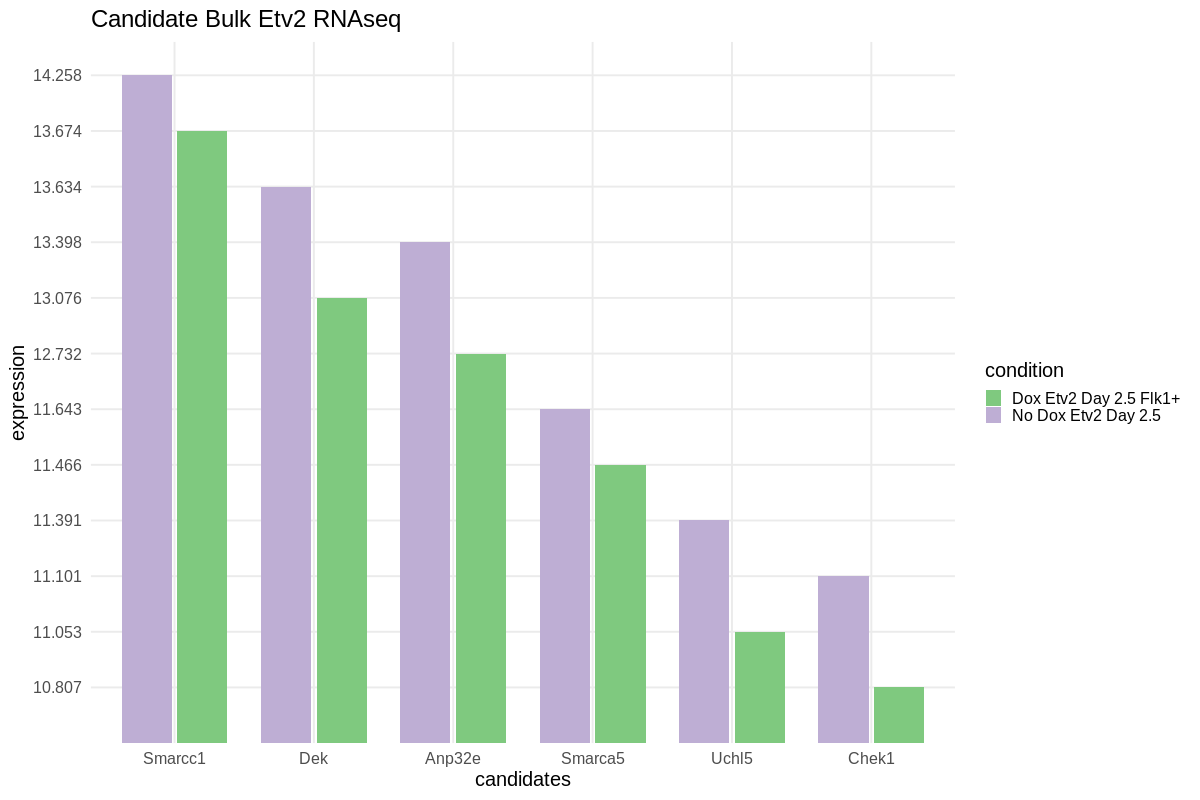

In [195]:
#@title plot Bulk RNA seq Expression
%%R -w 1200 -h 800
p1 = ggplot(data = dat, aes(x = candidates, y = expression, fill = condition)) + 
geom_bar(stat = "identity", position=position_dodge2(reverse = TRUE), width = 0.8) + scale_fill_brewer(palette="Accent") + theme_minimal(base_size=20) + 
ggtitle((label = "Candidate Bulk Etv2 RNAseq"))
p1

In [187]:
#@title removing genes with lower expression in the No Dox condition than the Dox Flk1+ condition
%%R
failures = lapply(dat$candidates %>% unique(), function(x){
    data = dat[which(dat$candidates == x),]
    ratio = data$expression[which(data$condition == "No Dox Etv2 Day 2.5")] %>% as.numeric()/data$expression[which(data$condition == "Dox Etv2 Day 2.5 Flk1+")] %>% as.numeric()
    if(ratio > 1){
        return(TRUE)
    }
    else{
        return(FALSE)
    }
})
failures  = failures %>% unlist() %>% as.vector()
candidates = candidates[failures] # removing candidates with higher Flk+ expression than No Dox
message("candidates remaining:")
candidates

R[write to console]: candidates remaining:



[1] "Smarca5" "Dek"     "Smarcc1" "Anp32e"  "Chek1"   "Uchl5"  
